### **Import Libraries & Load Data**

In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
from glob import glob
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, average_precision_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, accuracy_score
from sklearn.metrics import classification_report
from sklearn.utils import resample
import tensorflow as tf
import time
from datetime import datetime
from datetime import timedelta
import json
import os
import glob

# let here be all the paths and datsets
train_dir = "/content/drive/MyDrive/NIH_processed/train"
test_dir  = "/content/drive/MyDrive/NIH_processed/test"
model_dir = "/content/drive/MyDrive/NIH_ChestXray/vgg16_models"
os.makedirs(model_dir, exist_ok=True)

# Helper to build dataframe from folder structure
def build_df_from_folder(folder):
    rows = []
    classes = sorted([d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))])
    for cls in classes:
        class_path = os.path.join(folder, cls)
        for ext in ("*.png", "*.jpg", "*.jpeg"):
            for p in glob.glob(os.path.join(class_path, ext)):
                rows.append({"path": p, "target_str": cls})
    df = pd.DataFrame(rows)
    return df

# Build dataframes from directories
train_all = build_df_from_folder(train_dir)
test_data = build_df_from_folder(test_dir)

In [ ]:
# Map class names to numeric labels (0,1). If more than 2 classes exist, mapping will still be deterministic.
unique_classes = sorted(train_all['target_str'].unique())
class_map = {name: i for i, name in enumerate(unique_classes)}
train_all['target'] = train_all['target_str'].map(class_map).astype(float)
test_data['target'] = test_data['target_str'].map(class_map).astype(float)


# Split train -> final_train_data + val_data (20% of train used for val)
final_train_data, val_data = train_test_split(
    train_all,
    test_size=0.2,
    stratify=train_all['target'],
    random_state=123
)

# Ensure columns used by flow_from_dataframe exist and are correct
final_train_data = final_train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)


In [ ]:
# DATA GENERATORS
train_datagen = ImageDataGenerator(
    rescale=1./255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.9,1.1]
)

val_test_datagen = ImageDataGenerator(rescale=1./255.0)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=final_train_data,
    directory=None,
    x_col='path',
    y_col='target',
    class_mode='raw',
    target_size=(224, 224),
    batch_size=32,
    seed=123
)

val_gen = val_test_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory=None,
    x_col='path',
    y_col='target',
    class_mode='raw',
    target_size=(224, 224),
    batch_size=32,
    seed=123
)

test_gen = val_test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=None,
    x_col='path',
    y_col='target',
    class_mode='raw',
    target_size=(224, 224),
    batch_size=len(test_data),  # Single batch for evaluation
    shuffle=False,
    seed=123
)

Found 4256 validated image filenames.
Found 1064 validated image filenames.
Found 1784 validated image filenames.


#### **Define Model & Comile**

In [ ]:
# MODEL DEFINITION
def build_vgg16_model():
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

    # Freeze all layers except last conv block
    for layer in base_model.layers:
        layer.trainable = (layer.name == "block5_conv3")

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu', name='fc2')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid', name='predictions')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(
        optimizer=Adam(learning_rate=3e-3),
        loss='binary_crossentropy',
        metrics=[
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.BinaryAccuracy(name='binary_accuracy')
        ]
    )
    return model

model = build_vgg16_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 2,491,393 (9.50 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

In [ ]:
# TRAINING UTILITIES
class TrainingTracker:
    def __init__(self):
        self.start_time = None
        self.total_seconds = 0
        self.sessions = []

    def start_session(self):
        self.start_time = time.time()

    def end_session(self):
        if self.start_time:
            duration = time.time() - self.start_time
            self.total_seconds += duration
            self.sessions.append(duration)
            self.start_time = None

    def get_elapsed_time(self):
        return str(timedelta(seconds=int(self.total_seconds)))

    def save_progress(self, path):
        with open(path, 'w') as f:
            f.write(f"Total Training Time: {self.get_elapsed_time()}\n")
            f.write(f"Completed Sessions: {len(self.sessions)}\n")
            for i, session in enumerate(self.sessions, 1):
                f.write(f"Session {i}: {timedelta(seconds=int(session))}\n")

def get_model_size_mb(model_path):
    return os.path.getsize(model_path) / (1024 * 1024)

def load_previous_state(model_dir):
    # look for previous best files (if any)
    model_files = sorted(glob.glob(os.path.join(model_dir, 'vgg16_best_*.h5')))
    if not model_files:
        return None, 0

    latest_model = model_files[-1]
    # no epoch encoding in best filename; return 0 for start epoch
    return latest_model, 0

In [ ]:
# Calculate class weights
class_counts = final_train_data['target'].value_counts()
total_samples = class_counts.sum()
class_weights = {cls: total_samples / (len(class_counts) * count) for cls, count in class_counts.items()}
print("Class Weights:", class_weights)

Class Weights: {0.0: np.float64(0.6537634408602151), 1.0: np.float64(2.125874125874126)}


#### **Train Model**

In [ ]:
# TRAINING EXECUTION

# Initialize tracker and model directory
os.makedirs(model_dir, exist_ok=True)
tracker = TrainingTracker()
model_path, start_epoch = load_previous_state(model_dir)

if model_path:
    print(f"Resuming training from {model_path}")
    try:
        model = load_model(model_path, compile=False)
        model.compile(
            optimizer=Adam(learning_rate=3e-3),
            loss='binary_crossentropy',
            metrics=[
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc'),
                tf.keras.metrics.BinaryAccuracy(name='binary_accuracy')
            ]
        )
        # Load previous training time
        time_log = os.path.join(model_dir, 'training_time.log')
        if os.path.exists(time_log):
            with open(time_log, 'r') as f:
                time_str = f.readline().split(': ')[1].strip()
                h, m, s = map(int, time_str.split(':'))
                tracker.total_seconds = h*3600 + m*60 + s
    except Exception as e:
        print(f"Failed to load model: {e}\nInitializing new model")
        model = build_vgg16_model()
        start_epoch = 0
else:
    print("No previous model found - initializing new model")
    model = build_vgg16_model()
    start_epoch = 0

# Training callbacks
# only save the best model (monitored on val_loss)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
best_model_filename = f"vgg16_best_{timestamp}.h5"

callbacks = [
    ModelCheckpoint(
        filepath=os.path.join(model_dir, best_model_filename),
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.8,
        patience=4,
        min_lr=0.0001,
        cooldown=5
    ),
    tf.keras.callbacks.LambdaCallback(
        on_train_begin=lambda logs: tracker.start_session(),
        on_train_end=lambda logs: tracker.end_session(),
        on_epoch_end=lambda epoch, logs: (
            tracker.save_progress(os.path.join(model_dir, 'training_time.log')),
            print(f"Epoch {epoch+1:02d} | "
                  f"Elapsed: {tracker.get_elapsed_time()}")
        )
    )
]

# Start training
print(f"\n{'='*50}")
print("\nTraining Summary:")
print(f"Training Samples: {len(final_train_data)}")
print(f"Validation Samples: {len(val_data)}")
print(f"Starting Epoch: {start_epoch + 1}")
#print(f"Current Time: {tracker.get_elapsed_time()}\n")
print(f"{'='*50}\n")

history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=30,
    initial_epoch=start_epoch,
    validation_data=val_gen,
    validation_steps=len(val_gen),
    callbacks=callbacks,
    class_weight=class_weights, # Add class weights here
    verbose=1
)

No previous model found - initializing new model


Training Summary:
Training Samples: 4256
Validation Samples: 1064
Starting Epoch: 1

Epoch 1/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - auc: 0.5520 - binary_accuracy: 0.5557 - loss: 1.2268 - precision: 0.2836 - recall: 0.5556 
Epoch 1: val_loss improved from inf to 0.52597, saving model to /content/drive/MyDrive/NIH_ChestXray/vgg16_models/vgg16_best_20250815_193933.h5


Epoch 01 | Elapsed: 0:00:00
133/133 ━━━━━━━━━━━━━━━━━━━━ 3432s 26s/step - auc: 0.5523 - binary_accuracy: 0.5559 - loss: 1.2240 - precision: 0.2838 - recall: 0.5559 - val_auc: 0.6824 - val_binary_accuracy: 0.7321 - val_loss: 0.5260 - val_precision: 0.4022 - val_recall: 0.2880 - learning_rate: 0.0030
Epoch 2/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - auc: 0.6670 - binary_accuracy: 0.5882 - loss: 0.6642 - precision: 0.3317 - recall: 0.6596
Epoch 2: val_loss did not improve from 0.52597
Epoch 02 | Elapsed: 0:00:00
133/133 ━━━━━━━━━━━━━━━━━━━━ 553s 4s/step - auc: 0.6671 - binary_accuracy: 0.5885 - loss: 0.6640 - precision: 0.3318 - recall: 0.6596 - val_auc: 0.7320 - val_binary_accuracy: 0.6974 - val_loss: 0.5910 - val_precision: 0.4011 - val_recall: 0.5840 - learning_rate: 0.0030
Epoch 3/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - auc: 0.7507 - binary_accuracy: 0.7040 - loss: 0.5953 - precision: 0.4164 - recall: 0.7134
Epoch 3: val_loss improved from 0.52597 to 0.51742, saving model to /

Epoch 03 | Elapsed: 0:00:00
133/133 ━━━━━━━━━━━━━━━━━━━━ 545s 4s/step - auc: 0.7506 - binary_accuracy: 0.7039 - loss: 0.5954 - precision: 0.4163 - recall: 0.7132 - val_auc: 0.7509 - val_binary_accuracy: 0.7632 - val_loss: 0.5174 - val_precision: 0.4955 - val_recall: 0.4360 - learning_rate: 0.0030
Epoch 4/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - auc: 0.7416 - binary_accuracy: 0.7138 - loss: 0.6066 - precision: 0.4337 - recall: 0.6589
Epoch 4: val_loss did not improve from 0.51742
Epoch 04 | Elapsed: 0:00:00
133/133 ━━━━━━━━━━━━━━━━━━━━ 541s 4s/step - auc: 0.7417 - binary_accuracy: 0.7138 - loss: 0.6065 - precision: 0.4337 - recall: 0.6592 - val_auc: 0.7627 - val_binary_accuracy: 0.7331 - val_loss: 0.5433 - val_precision: 0.4497 - val_recall: 0.6080 - learning_rate: 0.0030
Epoch 5/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - auc: 0.7631 - binary_accuracy: 0.7222 - loss: 0.5798 - precision: 0.4395 - recall: 0.7201
Epoch 5: val_loss did not improve from 0.51742
Epoch 05 | Elapsed: 0:00

Epoch 06 | Elapsed: 0:00:00
133/133 ━━━━━━━━━━━━━━━━━━━━ 548s 4s/step - auc: 0.7612 - binary_accuracy: 0.6968 - loss: 0.5903 - precision: 0.4136 - recall: 0.6944 - val_auc: 0.7664 - val_binary_accuracy: 0.7613 - val_loss: 0.5091 - val_precision: 0.4921 - val_recall: 0.5000 - learning_rate: 0.0030
Epoch 7/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - auc: 0.7762 - binary_accuracy: 0.7267 - loss: 0.5675 - precision: 0.4354 - recall: 0.6835
Epoch 7: val_loss did not improve from 0.50914
Epoch 07 | Elapsed: 0:00:00
133/133 ━━━━━━━━━━━━━━━━━━━━ 544s 4s/step - auc: 0.7762 - binary_accuracy: 0.7267 - loss: 0.5675 - precision: 0.4354 - recall: 0.6836 - val_auc: 0.7711 - val_binary_accuracy: 0.6645 - val_loss: 0.6256 - val_precision: 0.3878 - val_recall: 0.7400 - learning_rate: 0.0030
Epoch 8/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - auc: 0.7852 - binary_accuracy: 0.7045 - loss: 0.5681 - precision: 0.4375 - recall: 0.7450
Epoch 8: val_loss did not improve from 0.50914
Epoch 08 | Elapsed: 0:00

Epoch 11 | Elapsed: 0:00:00
133/133 ━━━━━━━━━━━━━━━━━━━━ 548s 4s/step - auc: 0.7738 - binary_accuracy: 0.7273 - loss: 0.5695 - precision: 0.4404 - recall: 0.7043 - val_auc: 0.7778 - val_binary_accuracy: 0.7566 - val_loss: 0.5004 - val_precision: 0.4847 - val_recall: 0.5720 - learning_rate: 0.0024
Epoch 12/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - auc: 0.7801 - binary_accuracy: 0.7132 - loss: 0.5706 - precision: 0.4397 - recall: 0.7380
Epoch 12: val_loss did not improve from 0.50036
Epoch 12 | Elapsed: 0:00:00
133/133 ━━━━━━━━━━━━━━━━━━━━ 547s 4s/step - auc: 0.7801 - binary_accuracy: 0.7132 - loss: 0.5706 - precision: 0.4396 - recall: 0.7380 - val_auc: 0.7774 - val_binary_accuracy: 0.7227 - val_loss: 0.5480 - val_precision: 0.4413 - val_recall: 0.6760 - learning_rate: 0.0024
Epoch 13/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - auc: 0.7952 - binary_accuracy: 0.7325 - loss: 0.5490 - precision: 0.4558 - recall: 0.7338
Epoch 13: val_loss did not improve from 0.50036
Epoch 13 | Elapsed: 

#### **Plot History**

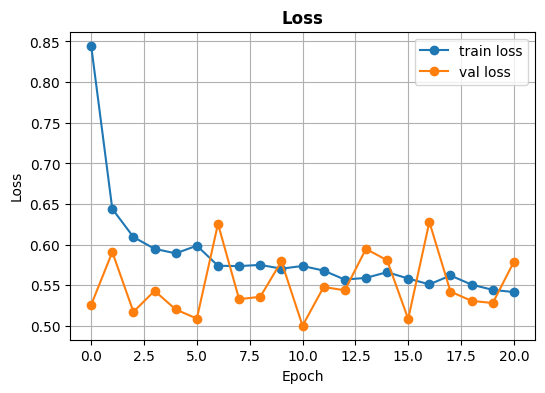

In [ ]:
import matplotlib.pyplot as plt

hist = history.history
plt.figure(figsize=(6,4))
plt.plot(hist['loss'], marker='o', label='train loss')
plt.plot(hist['val_loss'], marker='o', label='val loss')
plt.title('Loss', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

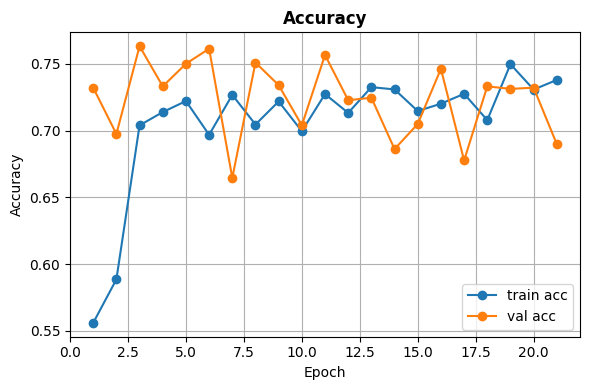

In [ ]:
import matplotlib.pyplot as plt

# Accuracy values manually extracted from your training log
train_acc = [
    0.5559, 0.5885, 0.7039, 0.7138, 0.7221, 0.6968, 0.7267, 0.7045, 0.7218, 0.6995,
    0.7273, 0.7132, 0.7325, 0.7308, 0.7146, 0.7201, 0.7275, 0.7078, 0.7497, 0.7307,
    0.7379
]

val_acc = [
    0.7321, 0.6974, 0.7632, 0.7331, 0.7500, 0.7613, 0.6645, 0.7509, 0.7340, 0.7039,
    0.7566, 0.7227, 0.7246, 0.6861, 0.7049, 0.7462, 0.6776, 0.7331, 0.7312, 0.7321,
    0.6898
]

epochs = list(range(1, len(train_acc) + 1))

# Plotting accuracy
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_acc, marker='o', label='train acc')
plt.plot(epochs, val_acc, marker='o', label='val acc')
plt.title('Accuracy', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### **Evaluation**

Loading best model: /content/drive/MyDrive/NIH_ChestXray/vgg16_models/vgg16_best_20250815_193933.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 206s 206s/step - auc: 0.7947 - binary_accuracy: 0.7556 - loss: 0.5102 - precision: 0.5696 - recall: 0.6074

Test Loss: 0.5102
Test Accuracy: 0.75561
1/1 ━━━━━━━━━━━━━━━━━━━━ 196s 196s/step

Classification Report:
              precision    recall  f1-score   support

      normal     0.8376    0.8153    0.8263      1272
   pneumonia     0.5696    0.6074    0.5879       512

    accuracy                         0.7556      1784
   macro avg     0.7036    0.7113    0.7071      1784
weighted avg     0.7607    0.7556    0.7579      1784



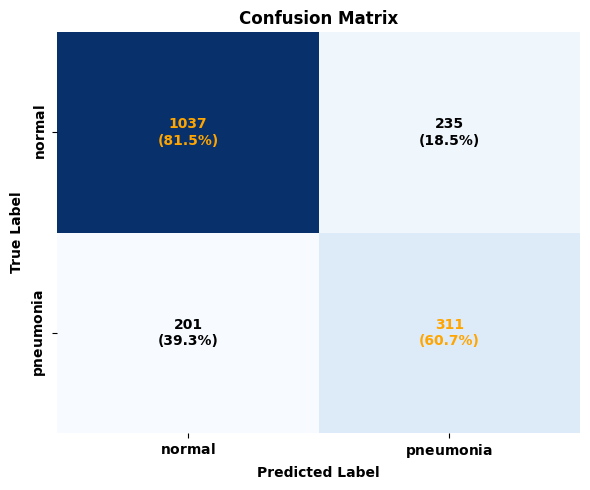

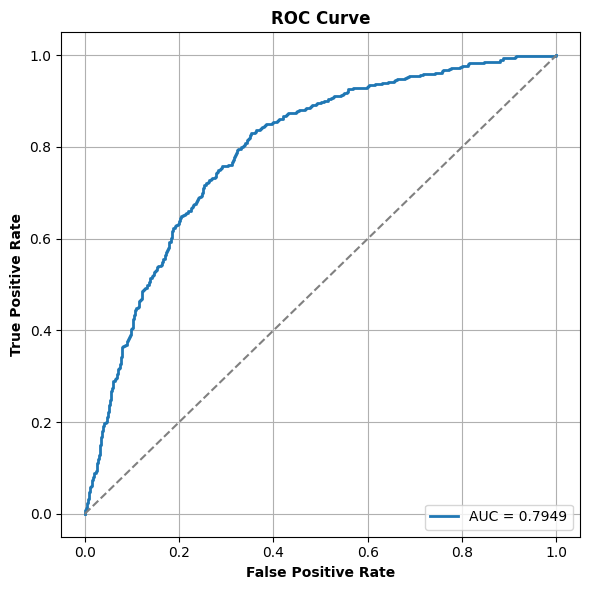


Model Size: 75.74 MB


In [ ]:
# EVALUATION
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import glob, os
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Define model_dir within this cell
model_dir = "/content/drive/MyDrive/NIH_ChestXray/vgg16_models"


# Load the latest saved "best" VGG model (pattern: vgg16_best_YYYYmmdd_HHMMSS.h5)
best_files = sorted(glob.glob(os.path.join(model_dir, "vgg16_best_*.h5")))
best_model_path = best_files[-1]  # Get the path of the latest saved best model
print("Loading best model:", best_model_path)
model = load_model(best_model_path)

# Re-compile the model with the same metrics after loading
model.compile(
    optimizer=Adam(learning_rate=3e-3),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.BinaryAccuracy(name='binary_accuracy')
    ]
)

# Evaluate the model on the test set
# Unpack all the metrics returned by model.evaluate
loss, precision, recall, auc, binary_accuracy = model.evaluate(test_gen, verbose=1)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {binary_accuracy:.5f}")
# print(f"Test Precision: {precision:.4f}")
# print(f"Test Recall: {recall:.4f}")
# print(f"Test AUC: {auc:.4f}")


# Get predictions
y_true  = test_data['target'].values # Get true labels from test_data DataFrame
y_probs = model.predict(test_gen, verbose=1).ravel()
y_pred  = (y_probs > 0.50).astype(int)

# Classification report (4 decimals)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(class_map.keys()), digits=4))

# Confusion matrix with counts + row-wise %
cm = confusion_matrix(y_true, y_pred)
cm_percent = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100.0

plt.figure(figsize=(6, 5))
ax = sns.heatmap(
    cm,
    annot=False,
    fmt='d',
    cmap='Blues',
    xticklabels=[f"$\\bf{{{lbl}}}$" for lbl in class_map.keys()],
    yticklabels=[f"$\\bf{{{lbl}}}$" for lbl in class_map.keys()],
    cbar=False
)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        pct = cm_percent[i, j]
        ax.text(
            j + 0.5,
            i + 0.5,
            f"{count}\n({pct:.1f}%)",
            ha='center',
            va='center',
            color='orange' if i == j else 'black',
            fontweight='bold'
        )
plt.title("Confusion Matrix", fontweight='bold')
plt.xlabel("Predicted Label", fontweight='bold')
plt.ylabel("True Label", fontweight='bold')
plt.tight_layout()
plt.show()

# ROC AUC
auc_score = roc_auc_score(y_true, y_probs)
fpr, tpr, _ = roc_curve(y_true, y_probs)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", linewidth=2)
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.title("ROC Curve", fontweight='bold')
plt.xlabel("False Positive Rate", fontweight='bold')
plt.ylabel("True Positive Rate", fontweight='bold')
plt.legend(loc="lower right", frameon=True)
plt.grid(True)
plt.tight_layout()
plt.show()

# Model size
model_size_mb = os.path.getsize(best_model_path) / (1024 * 1024)
print(f"\nModel Size: {model_size_mb:.2f} MB")

#### **Optional: Testing with manual and optimal thresholds**

Loading best model: /content/drive/MyDrive/NIH_ChestXray/vgg16_models/vgg16_best_20250815_193933.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 198s 198s/step - auc: 0.7947 - binary_accuracy: 0.7556 - loss: 0.5102 - precision: 0.5696 - recall: 0.6074

Test Loss: 0.5102
Test Accuracy: 0.75561
1/1 ━━━━━━━━━━━━━━━━━━━━ 193s 193s/step

Classification Report:
              precision    recall  f1-score   support

      normal     0.8661    0.7476    0.8025      1272
   pneumonia     0.5321    0.7129    0.6093       512

    accuracy                         0.7377      1784
   macro avg     0.6991    0.7303    0.7059      1784
weighted avg     0.7702    0.7377    0.7471      1784



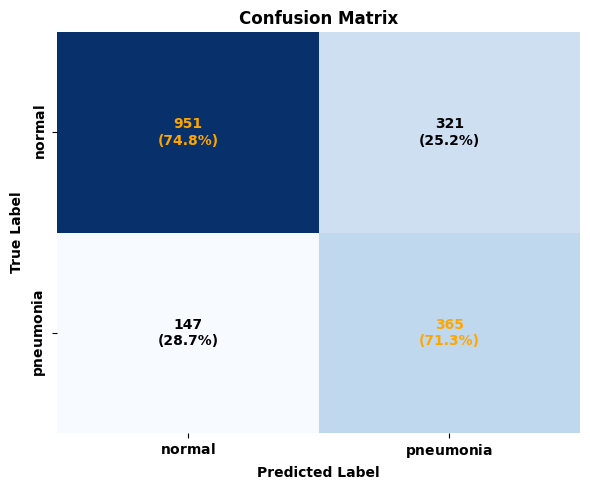

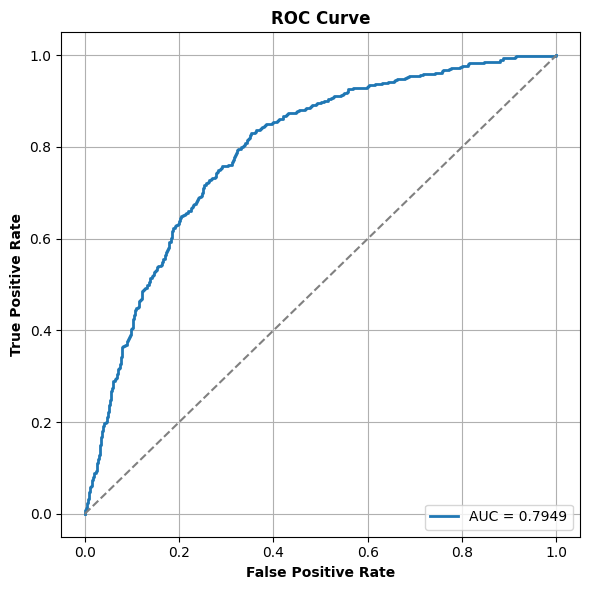


Model Size: 75.74 MB


In [ ]:
# ======================
# EVALUATION
# ======================
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import glob, os
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Define model_dir within this cell
model_dir = "/content/drive/MyDrive/NIH_ChestXray/vgg16_models"


# Load the latest saved "best" VGG model (pattern: vgg16_best_YYYYmmdd_HHMMSS.h5)
best_files = sorted(glob.glob(os.path.join(model_dir, "vgg16_best_*.h5")))
best_model_path = best_files[-1]  # Get the path of the latest saved best model
print("Loading best model:", best_model_path)
model = load_model(best_model_path)

# Re-compile the model with the same metrics after loading
model.compile(
    optimizer=Adam(learning_rate=3e-3),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.BinaryAccuracy(name='binary_accuracy')
    ]
)

# Evaluate the model on the test set
# Unpack all the metrics returned by model.evaluate
loss, precision, recall, auc, binary_accuracy = model.evaluate(test_gen, verbose=1)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {binary_accuracy:.5f}")
# print(f"Test Precision: {precision:.4f}")
# print(f"Test Recall: {recall:.4f}")
# print(f"Test AUC: {auc:.4f}")


# Get predictions
y_true  = test_data['target'].values # Get true labels from test_data DataFrame
y_probs = model.predict(test_gen, verbose=1).ravel()
y_pred  = (y_probs > 0.40).astype(int)

# Classification report (4 decimals)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(class_map.keys()), digits=4))

# Confusion matrix with counts + row-wise %
cm = confusion_matrix(y_true, y_pred)
cm_percent = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100.0

plt.figure(figsize=(6, 5))
ax = sns.heatmap(
    cm,
    annot=False,
    fmt='d',
    cmap='Blues',
    xticklabels=[f"$\\bf{{{lbl}}}$" for lbl in class_map.keys()],
    yticklabels=[f"$\\bf{{{lbl}}}$" for lbl in class_map.keys()],
    cbar=False
)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        pct = cm_percent[i, j]
        ax.text(
            j + 0.5,
            i + 0.5,
            f"{count}\n({pct:.1f}%)",
            ha='center',
            va='center',
            color='orange' if i == j else 'black',
            fontweight='bold'
        )
plt.title("Confusion Matrix", fontweight='bold')
plt.xlabel("Predicted Label", fontweight='bold')
plt.ylabel("True Label", fontweight='bold')
plt.tight_layout()
plt.show()

# ROC AUC
auc_score = roc_auc_score(y_true, y_probs)
fpr, tpr, _ = roc_curve(y_true, y_probs)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", linewidth=2)
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.title("ROC Curve", fontweight='bold')
plt.xlabel("False Positive Rate", fontweight='bold')
plt.ylabel("True Positive Rate", fontweight='bold')
plt.legend(loc="lower right", frameon=True)
plt.grid(True)
plt.tight_layout()
plt.show()

# Model size
model_size_mb = os.path.getsize(best_model_path) / (1024 * 1024)
print(f"\nModel Size: {model_size_mb:.2f} MB")

Loading best model: /content/drive/MyDrive/NIH_ChestXray/vgg16_models/vgg16_best_20250815_193933.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 244s 244s/step - auc: 0.7947 - binary_accuracy: 0.7556 - loss: 0.5102 - precision: 0.5696 - recall: 0.6074

Test Loss: 0.5102
Test Accuracy: 0.75561
1/1 ━━━━━━━━━━━━━━━━━━━━ 252s 252s/step

Optimal Threshold: 0.3197

Classification Report (Optimal Threshold):
              precision    recall  f1-score   support

      normal     0.9034    0.6470    0.7540      1272
   pneumonia     0.4857    0.8281    0.6123       512

    accuracy                         0.6990      1784
   macro avg     0.6945    0.7376    0.6831      1784
weighted avg     0.7835    0.6990    0.7133      1784



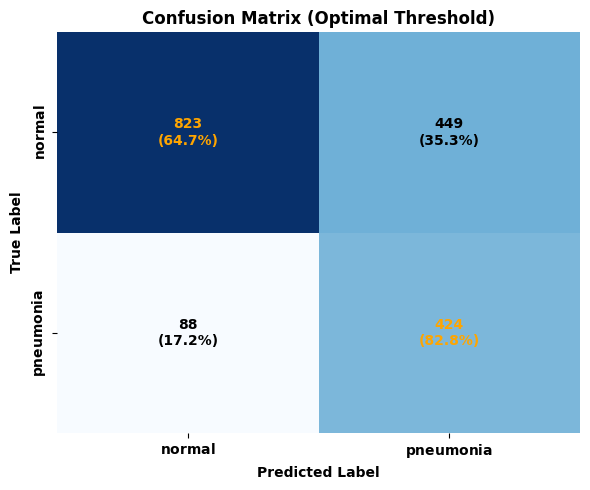

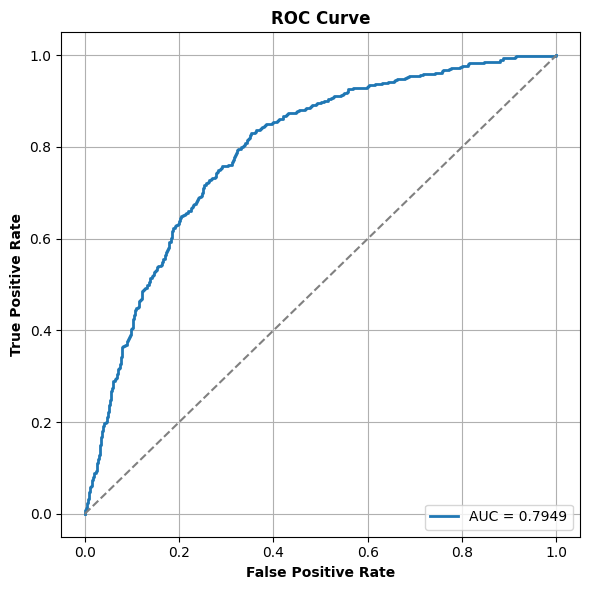


Model Size: 75.74 MB


In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

best_model_path = "/content/drive/MyDrive/NIH_ChestXray/vgg16_models/vgg16_best_20250815_193933.h5"
print("Loading best model:", best_model_path)
model = load_model(best_model_path)

model.compile(
    optimizer=Adam(learning_rate=3e-3),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.BinaryAccuracy(name='binary_accuracy')
    ]
)

loss, precision, recall, auc, binary_accuracy = model.evaluate(test_gen, verbose=1)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {binary_accuracy:.5f}")

y_true = test_data['target'].values
y_probs = model.predict(test_gen, verbose=1).ravel()

fpr, tpr, thresholds = roc_curve(y_true, y_probs)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"\nOptimal Threshold: {optimal_threshold:.4f}")

y_pred_opt = (y_probs > optimal_threshold).astype(int)

print("\nClassification Report (Optimal Threshold):")
print(classification_report(y_true, y_pred_opt, target_names=list(class_map.keys()), digits=4))

cm = confusion_matrix(y_true, y_pred_opt)
cm_percent = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100.0

plt.figure(figsize=(6, 5))
ax = sns.heatmap(
    cm,
    annot=False,
    fmt='d',
    cmap='Blues',
    xticklabels=[f"$\\bf{{{lbl}}}$" for lbl in class_map.keys()],
    yticklabels=[f"$\\bf{{{lbl}}}$" for lbl in class_map.keys()],
    cbar=False
)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        pct = cm_percent[i, j]
        ax.text(
            j + 0.5,
            i + 0.5,
            f"{count}\n({pct:.1f}%)",
            ha='center',
            va='center',
            color='orange' if i == j else 'black',
            fontweight='bold'
        )
plt.title("Confusion Matrix (Optimal Threshold)", fontweight='bold')
plt.xlabel("Predicted Label", fontweight='bold')
plt.ylabel("True Label", fontweight='bold')
plt.tight_layout()
plt.show()

auc_score = roc_auc_score(y_true, y_probs)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", linewidth=2)
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.title("ROC Curve", fontweight='bold')
plt.xlabel("False Positive Rate", fontweight='bold')
plt.ylabel("True Positive Rate", fontweight='bold')
plt.legend(loc="lower right", frameon=True)
plt.grid(True)
plt.tight_layout()
plt.show()

model_size_mb = os.path.getsize(best_model_path) / (1024 * 1024)
print(f"\nModel Size: {model_size_mb:.2f} MB")